# IPython Notebook to evaluate the observables output of our program

## Importing the required libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt

## Import mcutils.py library to be found in project folder

In [2]:
from mcutils import *    #Documentation see mcutils.py

## Import and plot the observables as a function of Montecarlo steps

### Tune n_th to remove any effects of thermalisation. The HMC hamiltonian seems to be the clearest indicator for when thermalisation is completed

In [3]:
#n_th = 0
n_th = 1000

[['N', 'P', 'M', 'v0', 'beta', 'num_steps'], ['10', '50', '47', '2.000000e-01', '7.000000e-01', '50000']]


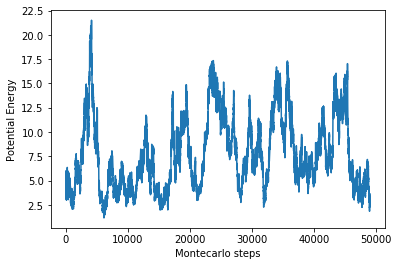

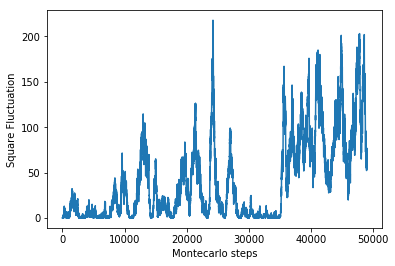

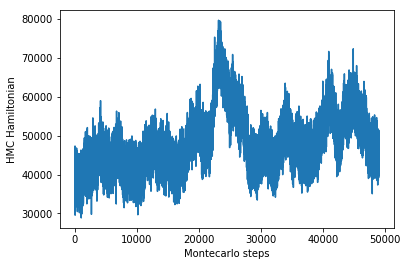

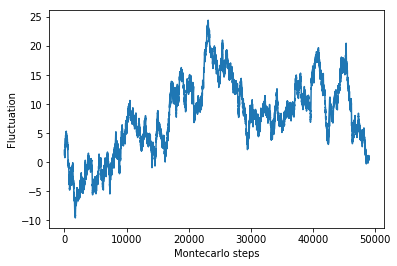

In [12]:
#obsfilePath = 'outputs/'
#obsfilePath = 'outputs/out_M_47_P_50.txt'
obsfilePath = 'sample-outputs/out_M_47_P_50.txt'    #As demanded in the exercise
#obsfilePath = 'sample-outputs/out_M_80_P_100.txt'
#obsfilePath = 'sample-outputs/out_M_120_P_200.txt'   #N = 10, P = 200
obsData = importObsData(obsfilePath)
parameters = obsData[0]
obsData = obsData[1]
print(parameters)
noTherm = [obsData[1][n_th:],obsData[2][n_th:],obsData[3][n_th:],obsData[4][n_th:]]
makePlot([np.arange(len(noTherm[0])),noTherm[0]], "Potential Energy")
makePlot([np.arange(len(noTherm[1])),noTherm[1]], "Square Fluctuation")
makePlot([np.arange(len(noTherm[2])),noTherm[2]], "HMC Hamiltonian")
makePlot([np.arange(len(noTherm[3])),noTherm[3]], "Fluctuation")

### The higher P we chose, the more stable the simulation gets. See the HMC Hamiltonian for reference. In the Potential Energy and the Square Fluctuation we see that the period of the oscillations gets longer with higher P

## Plot histogram of the observables to check the distribution of values
### Each histogram is made of 100 equally-spaced bins

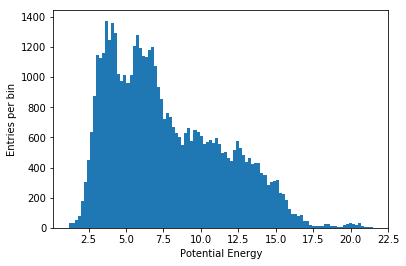

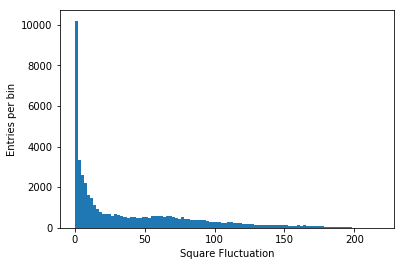

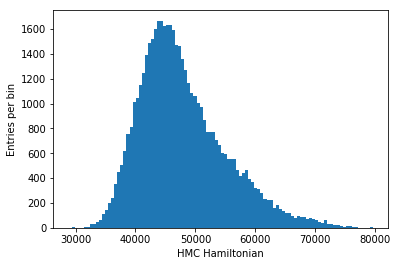

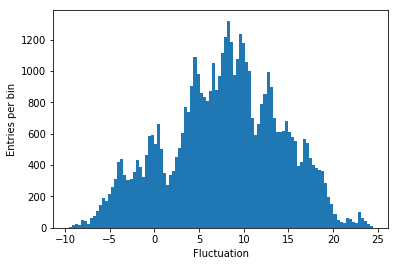

In [10]:
plt.hist(obsData[1][n_th:], 100)
plt.xlabel("Potential Energy")
plt.ylabel("Entries per bin")
plt.show()
plt.hist(obsData[2][n_th:], 100)
plt.xlabel("Square Fluctuation")
plt.ylabel("Entries per bin")
plt.show()
plt.hist(obsData[3][n_th:], 100)
plt.xlabel("HMC Hamiltonian")
plt.ylabel("Entries per bin")
plt.show()
plt.hist(obsData[4][n_th:], 100)
plt.xlabel("Fluctuation")
plt.ylabel("Entries per bin")
plt.show()

## Calculate the autocorrelation with an exponential fit
### The autocorrelation time is rather large, so that a high value of k_max has to be chosen to provide acceptable precision. Results supplied in the array tau_results were calculated with the results from the file 'outputs/out_M_120_P_200.txt' with k_max = 100000 taking about 60 minutes each to calculate in python

In [ ]:
autocorr_array, fitParams, tau_int = [],[],[]    #Empty lists to store results
k_max_tau_int = [10000, 25000]    #Sum cutoff value for integrated autocorrelation time
titles = ["Autocorrelation of Potential Energy", "Autocorrelation of Square Fluctuation"]
for i in [0]:
    k_max = 50000    #Maximum k to calculate autocorrelation up to
    autocorr_array.append(calc_autocorr(noTherm[i], k_max))    #Save autocorrelation
    fitParams.append(fit_autocorr_time(autocorr_array[i], k_max))    #Exponential fit to autocorr data
    tau_int.append(integrated_autocorr_time(autocorr_array[i][:k_max_tau_int[i]]))    #Calculate integrated autocorr time
    makeFitPlot(autocorr_array[i], k_max, fitParams[i][0], fitParams[i][1], titles[i])
    print("tau_exp: %.0f \t tau_int: %.0f"%(fitParams[i][1], tau_int[i]))

In [ ]:
sin_fitfkt = lambda t,a,b,phi : a*np.sin(b*t+phi)

In [ ]:
opt.curve_fit(sin_fitfkt, np.arange(15000,len(autocorr_array[0][15000:])+15000), autocorr_array[0][15000:], p0=(0.5,2*np.pi/25000,0))

### The tail of negative autocorrelation is surprising. According to http://www.pmean.com/09/NegativeAutocorrelation.html it can indicate an oscillation of the observable around its average value meaning that if the value at step i is above average, step i+1 is likely to be below average. However as to be seen in the plots above the fluctuation around the average value seems to have a much longer duration than just one step
### Including the negative tail in the exponential fit does not significantly change the value of tau

## Please compare the results from the exponential fit and the integrated autocorrelation.
### To get significant results for the integrated autocorrelation the sum is stopped when C(k)/C(0) approaches zero for the first time. For the Potential energy this is at k $\approx$ 10000 and for the Square of the Fluctuation it is at k $\approx$ 25000.

In [7]:
tau_results_exp = [2636,8372]
tau_results_int = [3093,7091]

In [8]:
print("\t \t tau_exp \t tau_int")
print("Pot. E. \t %4.0f \t\t %04.0f"%(tau_results_exp[0], tau_results_int[0]))
print("Sq. Fluct. \t %4.0f \t\t %04.0f"%(tau_results_exp[1], tau_results_int[1]))

	 	 tau_exp 	 tau_int
Pot. E. 	 2636 		 2500
Sq. Fluct. 	 8372 		 2500


## Final result using the tau from the exponential fit
### The error is calculated according to $$err(X) = \frac{\sigma(X)}{\frac{N}{2\tau}}$$ with $\sigma(X)$ being the standard deviation of the observable in array X of length N

### This cell uses the results providid in tau_results...

In [9]:
print("Expectation value for the Potential Energy: %.2f +- %.2f"%(np.mean(noTherm[0]), np.std(noTherm[0])/np.sqrt(len(noTherm[0])/(2*tau_results_exp[0]))))
print("Expectation value for the Square Fluctuation: %.1f +- %.1f"%(np.mean(noTherm[1]), np.std(noTherm[1])/np.sqrt(len(noTherm[1])/(2*tau_results_exp[1]))))

Expectation value for the Potential Energy: 4.99 +- 0.45
Expectation value for the Square Fluctuation: 58.2 +- 15.7


### ...if you want to use your own calculations of tau, uncomment these lines

In [10]:
#print("Expectation value for the Potential Energy: %.2f +- %.2f"%(np.mean(noTherm[0]), np.std(noTherm[0])/np.sqrt(len(noTherm[0])/(2*fitParams[0][1]))))
#print("Expectation value for the Square Fluctuation: %.1f +- %.1f"%(np.mean(noTherm[1]), np.std(noTherm[1])/np.sqrt(len(noTherm[1])/(2*fitParams[1][1]))))